In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
path_dir = './LFW-FER/eval/negative/'
file_list = os.listdir(path_dir)
# file_list[0]

In [16]:
#figure seting 

def fig_set(fig, rows, cols, num, img, label):
    ax = fig.add_subplot(rows, cols, num)
    ax.imshow(img)
    ax.set_xlabel(label)
    ax.set_xticks([]), ax.set_yticks([])

- plt.imshow()함수는 RGB 순으로 해석, OpenCV는 컬러 이미지를 BGR순으로 인식 하므로 컬러를 뒤집어서 나타내 주어야함

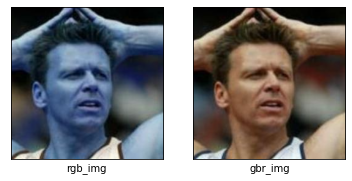

In [18]:
img = np.zeros((120, 120), dtype=np.uint8)
img_rgb = cv2.imread('./LFW-FER/eval/negative/Steve_Backley_0002.jpg')
img_gbr = img_rgb[:,:,::-1]

fig = plt.figure()
fig_set(fig, 1, 2, 1, img_rgb, 'rgb_img')
fig_set(fig, 1, 2, 2, img_gbr, 'gbr_img')

- img 자체에 연산을 하게 되면, 이미지 내에 있는 모든 배열의 벨류값에 100을 더해주게 된다.  
  -->  ```포화연산처리가 안되어 이미지 색상이 이상하게 나온다```
  * 포화연산: 픽셀 값이 최대치와 최소치를 넘으면 최대치와 최소치로 처리하는 연산

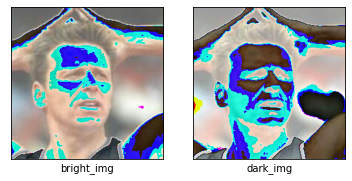

In [19]:
img1 = img_gbr + 100
img2 = img_gbr - 100

fig = plt.figure()

fig_set(fig, 1, 2, 1, img1, 'bright_img')
fig_set(fig, 1, 2, 2, img2, 'dark_img')

- int32: ```-2147483648 ~ 2147483648   (부호 있음)```
- Uint8: ```0 ~ 255                    (부호 없음)```

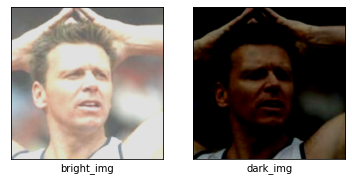

In [22]:
img1 = np.clip(img_gbr.astype('int32')+100,0,225).astype('uint8')
img2 = np.clip(img_gbr.astype('int32')-100,0,225).astype('uint8')

fig = plt.figure()

fig_set(fig, 1, 2, 1, img1, 'bright_img')
fig_set(fig, 1, 2, 2, img2, 'dark_img')

- Trackbar를 이용한 이미지 밝기 조절

In [32]:
def trackbar_bright(img, num):
    return np.clip(img.astype('int32')+num,0,225).astype('uint8')

def trackbar_dark(img, num):
    return np.clip(img.astype('int32')-num,0,225).astype('uint8')

In [33]:

cv2.imshow('img', img_rgb)
cv2.createTrackbar('bright', 'img', 0, 100, lambda pos: cv2.imshow('img', trackbar_bright(img_rgb, pos)))
cv2.createTrackbar('dark', 'img', 0, 100, lambda pos: cv2.imshow('img', trackbar_dark(img_rgb, pos)))
cv2.waitKey(0)
cv2.destroyAllWindows()

### Face Detection


- opencv의 사전학습 CascadeClassifier함수를 사용하여 얼굴 검출

In [40]:
src = cv2.imread('./LFW-FER/eval/negative/Steve_Backley_0002.jpg')

if src is None:
    print('Image load failed!')
    os.sys.exit()

# 객체 생성
classifier = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# 개체가 재대로 생성됬는지 확인
if classifier.empty():
    print('XML load failed!')
    os.sys.exit()

# 입력영상에서 얼굴을 검출
faces = classifier.detectMultiScale(src) # 스케일팩터를 1.2로 지정해도 잘 작동함 더 빨라짐

# 각각의 행마다 (x,y,w,h) 받아와서 사각형을 그리는 코드
for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)


cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()

- dlib를 사용하여 얼굴 검출

In [2]:
import dlib

- get_frontal_face_detector는 HOG(Histogram of Oriented Gradient) + SVM을 활용

In [17]:
detector = dlib.get_frontal_face_detector()
faces = detector(img)

for face in faces:
    left = face.left()
    right = face.right()
    top = face.top()
    bottom = face.bottom()
    print(left, right, top, bottom)
    # 위치 정보를 활용해 사각형 그리기
    img = cv2.rectangle(
        img, (left, top), (right, bottom), (0, 0, 255), 3
    )
    cv2.imwrite("face-rect.jpg", img)


65 189 79 203


In [4]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2


def main():
    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--shape-predictor", required=True, help="path to facial landmark predictor")
    ap.add_argument("-i", "--image", required=True, help="path to input image")
    ap.add_argument('--draw', nargs='?', const=True, type=bool, default=False, help="Fill landmarks")

    args = vars(ap.parse_args())

    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(args["shape_predictor"])

    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(args["image"])
    image = imutils.resize(image, width=500)

    if args['draw']:
        draw_individual_detections(image, detector, predictor)
    else:
        show_raw_detection(image, detector, predictor)


def show_raw_detection(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

    # show the output image with the face detections + facial landmarks
    cv2.imshow("Output", image)
    cv2.waitKey(0)


def draw_individual_detections(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            clone = image.copy()
            cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 0, 255), 2)

            # loop over the subset of facial landmarks, drawing the
            # specific face part
            for (x, y) in shape[i:j]:
                cv2.circle(clone, (x, y), 1, (0, 0, 255), -1)

            # extract the ROI of the face region as a separate image
            (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))
            roi = image[y:y + h, x:x + w]
            roi = imutils.resize(roi, width=250, inter=cv2.INTER_CUBIC)

            # show the particular face part
            cv2.imshow("ROI", roi)
            cv2.imshow("Image", clone)
            cv2.waitKey(0)

        # visualize all facial landmarks with a transparent overlay
        output = face_utils.visualize_facial_landmarks(image, shape)
        cv2.imshow("Image", output)
        cv2.waitKey(0)


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] -p SHAPE_PREDICTOR -i IMAGE [--draw [DRAW]]
ipykernel_launcher.py: error: the following arguments are required: -p/--shape-predictor, -i/--image


SystemExit: 2

c:\ProgramData\Anaconda3\envs\OpenCV\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
